# Setting up the environment

First, we set up our environment. We will be using a pre-compiled and packaged installation of OpenMM and the openmm-dlext plugin.
It will be downloaded from Google Drive and made accessible to the Python process running in this Colab instance.

In [1]:
%%bash

BASE_URL="https://drive.usercontent.google.com/download?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7"
COOKIES="/tmp/cookies.txt"
CONFIRMATION="$(wget -q --save-cookies $COOKIES --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')"

wget -q --load-cookies $COOKIES "$BASE_URL&confirm=$CONFIRMATION" -O pysages-env.zip
rm -rf $COOKIES

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [5]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

## PySAGES

Next, we install PySAGES. The latest version is retrieved from GitHub and installed (along with its dependencies) using `pip`.

In [6]:
!pip install -qq git+https://github.com/SSAGESLabs/PySAGES.git > /dev/null

# SpectralABF-biased simulations

SpectralABF gradually learns a better approximation to the coefficients of a basis functions expansion of the free energy of a system, from the generalized mean forces in a similar fashion to the ABF sampling method.

For this Colab, we are using alanine peptide in vacuum as example system.

In [8]:
%%bash

# Download pdb file with the initial configuration of our system
wget -q https://raw.githubusercontent.com/SSAGESLabs/PySAGES/main/examples/inputs/alanine-dipeptide/adp-vacuum.pdb

In [9]:
import numpy as np
import openmm
import openmm.app as app
import openmm.unit as unit


pi = np.pi
T = 298.15 * unit.kelvin
dt = 2.0 * unit.femtoseconds
adp_pdb = "adp-vacuum.pdb"


def generate_simulation(pdb_filename=adp_pdb, T=T, dt=dt, **kwargs):
    pdb = app.PDBFile(pdb_filename)

    ff = app.ForceField("amber99sb.xml")
    cutoff_distance = 1.0 * unit.nanometer
    topology = pdb.topology

    system = ff.createSystem(
        topology, constraints=app.HBonds, nonbondedMethod=app.PME, nonbondedCutoff=cutoff_distance
    )

    # Set dispersion correction use.
    forces = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        forces[force.__class__.__name__] = force

    forces["NonbondedForce"].setUseDispersionCorrection(True)
    forces["NonbondedForce"].setEwaldErrorTolerance(1.0e-5)

    positions = pdb.getPositions(asNumpy=True)

    integrator = openmm.LangevinIntegrator(T, 1 / unit.picosecond, dt)
    integrator.setRandomNumberSeed(42)

    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    return simulation

Next, we import PySAGES and the necessary classes and methods for our simulation

In [10]:
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.methods import SpectralABF

import pysages

The next step is to define the collective variable (CV). In this case, we choose the so called $\phi$ and $\psi$ dihedral angles of alanine dipeptide.

We define a grid, which will be used to indicate how we want to bin the forces that will be used to approximate the biasing potential and its gradient.

In [15]:
cvs = [DihedralAngle([4, 6, 8, 14]), DihedralAngle([6, 8, 14, 16])]
grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(64, 64), periodic=True)
timesteps = int(1e6)

method = SpectralABF(cvs, grid)

We now simulate the number of time steps set above.
For optimal performance, ensure that the simulation is executed with GPU acceleration. Otherwise, it may take a considerably longer time to complete.

In [16]:
run_result = pysages.run(method, generate_simulation, timesteps)

## Analysis

Let's plot the free energy!

In [18]:
import matplotlib.pyplot as plt

In [20]:
result = pysages.analyze(run_result)
A = result["free_energy"]
# Aternatively to the line above:
# mesh = result["mesh"]
# fes_fn = result["fes_fn"]
# A = fes_fn(mesh)
A = A.reshape(grid.shape)

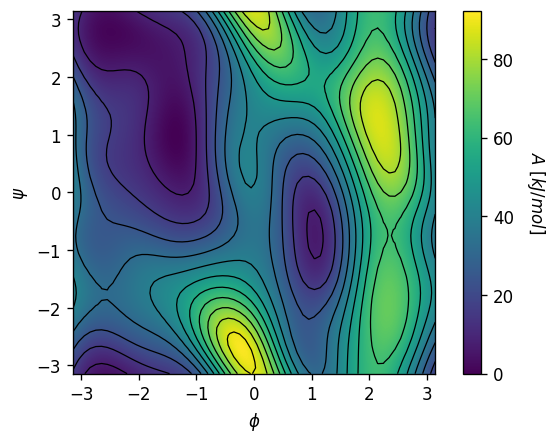

In [22]:
fig, ax = plt.subplots(dpi=120)

im = ax.imshow(
    A, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi]
)
ax.contour(
    A, levels=12, linewidths=0.75, colors="k", extent=[-pi, pi, -pi, pi]
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r"$A~[kJ/mol]$", rotation=270, labelpad=20)

fig.show()